In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

#Model tesets
from sklearn.linear_model import LogisticRegression
import joblib


In [2]:
X = pd.read_csv("X.csv", index_col=0)  
y_raw = pd.read_csv("y.csv")
y = y_raw["label"]

In [3]:
y = y.str.replace("leukemia class: ", "", regex=False)
y = y.str.strip()
print(y.value_counts())

label
CLL                                                448
AML with normal karyotype + other abnormalities    351
c-ALL/Pre-B-ALL without t(9;22)                    237
MDS                                                206
T-ALL                                              174
c-ALL/Pre-B-ALL with t(9;22)                       122
CML                                                 76
Non-leukemia and healthy bone marrow                74
Pro-B-ALL with t(11q23)/MLL                         70
ALL with t(12;21)                                   58
AML complex aberrant karyotype                      48
ALL with hyperdiploid karyotype                     40
AML with t(8;21)                                    40
AML with t(11q23)/MLL                               38
AML with t(15;17)                                   37
ALL with t(1;19)                                    36
AML with inv(16)/t(16;16)                           28
mature B-ALL with t(8;14)                           13
Name

/tmp/ipykernel_124093/1961879117.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, order=y.value_counts().index, palette="Set2")


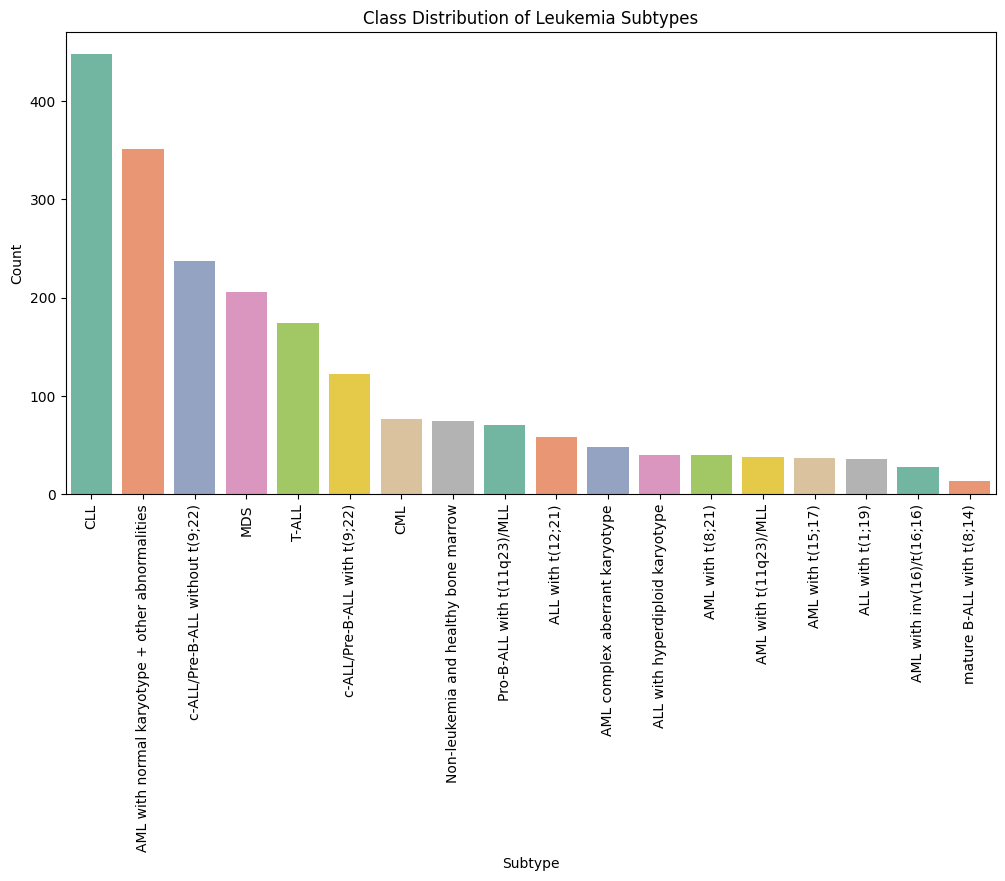

In [4]:
plt.figure(figsize=(12,6))
sns.countplot(x=y, order=y.value_counts().index, palette="Set2")
plt.xticks(rotation=90)
plt.title("Class Distribution of Leukemia Subtypes")
plt.xlabel("Subtype")
plt.ylabel("Count")
plt.show()

In [5]:
def map_label(label: str) -> str:
    label = label.upper()  # normalize
    
    if "ALL" in label:
        return "ALL"
    elif "AML" in label:
        return "AML"
    elif "CML" in label:
        return "CML"
    elif "CLL" in label:
        return "CLL"
    else:
        return "Other"  

In [6]:
y = y.apply(map_label)
print(y.value_counts())

label
ALL      750
AML      542
CLL      448
Other    280
CML       76
Name: count, dtype: int64


/tmp/ipykernel_124093/3581345899.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, order=y.value_counts().index, palette="Set2")


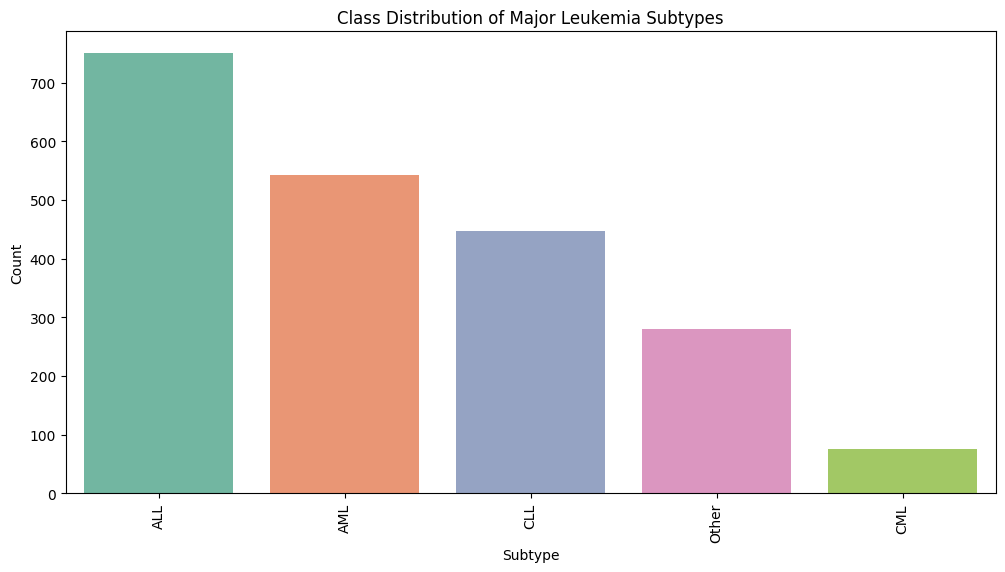

In [7]:
plt.figure(figsize=(12,6))
sns.countplot(x=y, order=y.value_counts().index, palette="Set2")
plt.xticks(rotation=90)
plt.title("Class Distribution of Major Leukemia Subtypes")
plt.xlabel("Subtype")
plt.ylabel("Count")
plt.show()

In [8]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(dict(zip(le.classes_, range(len(le.classes_)))))

{'ALL': 0, 'AML': 1, 'CLL': 2, 'CML': 3, 'Other': 4}


In [9]:
print("NaNs in data:", np.isnan(X.values).sum())
print("Infs in data:", np.isinf(X.values).sum())
X = X.fillna(0)

NaNs in data: 94320
Infs in data: 0


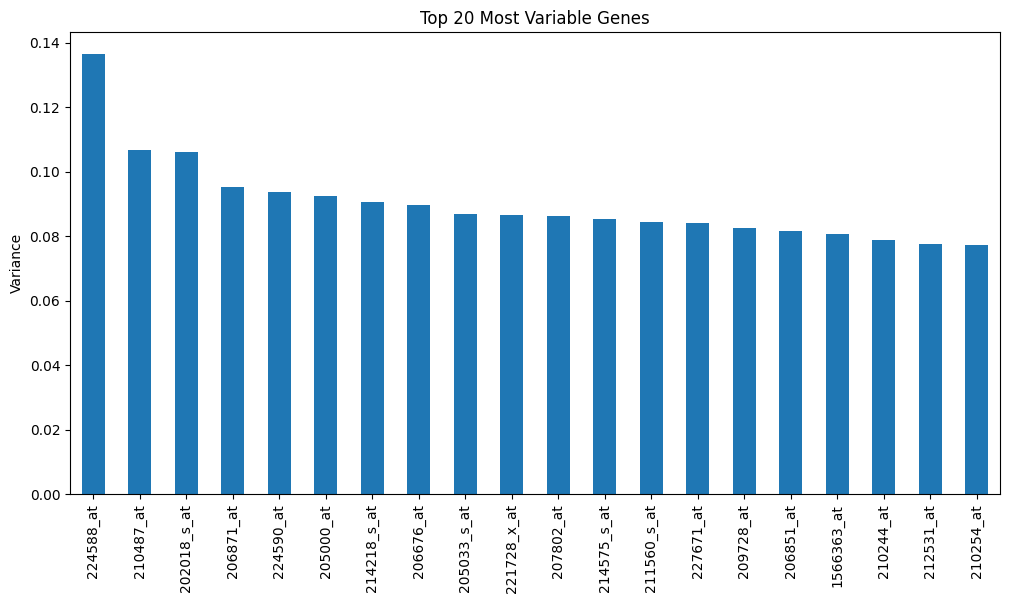

In [10]:
variances = X.var(axis=0).sort_values(ascending=False)[:20]

plt.figure(figsize=(12,6))
variances.plot(kind="bar")
plt.title("Top 20 Most Variable Genes")
plt.ylabel("Variance")
plt.show()


In [11]:
selector = SelectKBest(score_func=f_classif, k = 10000)
X_selected = selector.fit_transform(X, y_encoded)

/run/media/Saksham/Saksham/Code/Projects/Leukemia/Basic_4_types/myenv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [54613 54614 54615 54616 54617 54618 54619 54620 54621 54622 54623 54624
 54639 54640 54641 54645 54646 54647 54648 54649 54650 54651 54652 54653
 54654 54655 54656 54657 54658 54659 54660 54661 54662 54663 54664 54665
 54666 54667 54668 54669 54670 54671 54672 54673 54674] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/run/media/Saksham/Saksham/Code/Projects/Leukemia/Basic_4_types/myenv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

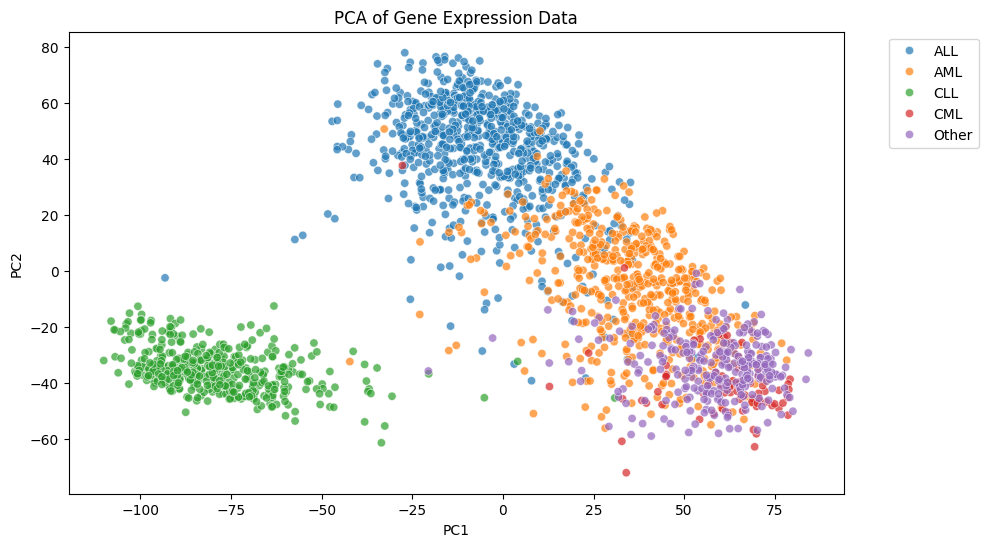

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="tab10", alpha=0.7)
plt.title("PCA of Gene Expression Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=69, stratify=y_encoded
)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1676, 10000) (1676,) (420, 10000) (420,)


In [16]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE :", np.bincount(y_res))

# X_train_res, y_train_res = X_train, y_train

Before SMOTE: [600 433 358  61 224]
After SMOTE : [600 600 600 600 600]


In [ ]:
log_reg = LogisticRegression(
    max_iter=10000, 
    solver="liblinear", 
    penalty="l2",
    C=1.0,
    random_state=69
)
log_reg.fit(X_res, y_res)


/run/media/Saksham/Saksham/Code/Projects/Leukemia/Basic_4_types/myenv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,69
,solver,'liblinear'
,max_iter,10000
,multi_class,'deprecated'


In [21]:
y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
cm_log_reg = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm_log_reg)

Accuracy: 0.9380952380952381

Classification Report:
               precision    recall  f1-score   support

         ALL       1.00      0.95      0.97       150
         AML       0.95      0.89      0.92       109
         CLL       0.99      0.99      0.99        90
         CML       0.58      1.00      0.73        15
       Other       0.85      0.91      0.88        56

    accuracy                           0.94       420
   macro avg       0.87      0.95      0.90       420
weighted avg       0.95      0.94      0.94       420


Confusion Matrix:
 [[142   1   1   5   1]
 [  0  97   0   4   8]
 [  0   0  89   1   0]
 [  0   0   0  15   0]
 [  0   4   0   1  51]]


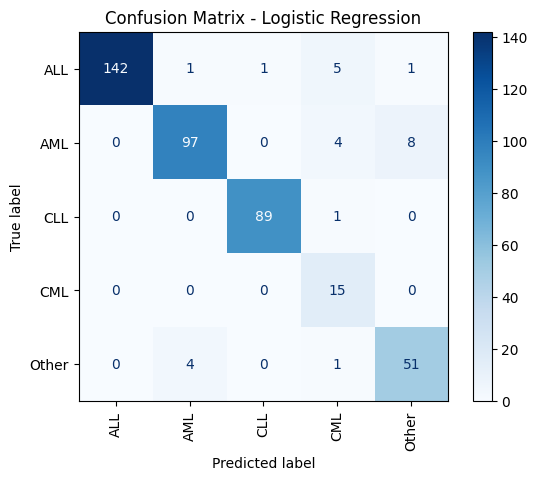

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=le.classes_)
disp.plot(xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [23]:
mlp = MLPClassifier(
    hidden_layer_sizes=(21, 78),  
    activation="logistic",         
    solver="adam",              
    max_iter=500,                   
    random_state=69,
    early_stopping=True,
    n_iter_no_change=20
)

mlp.fit(X_res, y_res)

,hidden_layer_sizes,"(21, ...)"
,activation,'logistic'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True
,random_state,69


In [24]:
y_pred = mlp.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
cm_mlp = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm_mlp)

Accuracy: 0.969047619047619

Classification Report:
               precision    recall  f1-score   support

         ALL       0.99      0.99      0.99       150
         AML       0.96      0.94      0.95       109
         CLL       0.99      1.00      0.99        90
         CML       0.94      1.00      0.97        15
       Other       0.89      0.91      0.90        56

    accuracy                           0.97       420
   macro avg       0.96      0.97      0.96       420
weighted avg       0.97      0.97      0.97       420


Confusion Matrix:
 [[149   0   1   0   0]
 [  1 102   0   0   6]
 [  0   0  90   0   0]
 [  0   0   0  15   0]
 [  0   4   0   1  51]]


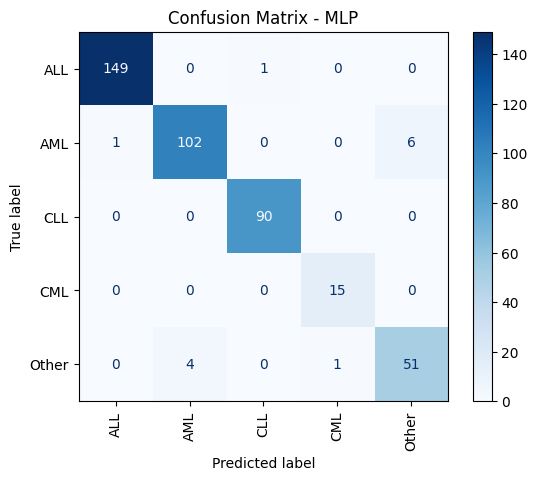

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=le.classes_)
disp.plot(xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix - MLP")
plt.show()

In [26]:
joblib.dump(log_reg, "log_reg_model.pkl")
joblib.dump(mlp, "mlp_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

print("Model, scaler, and label encoder saved.")

Model, scaler, and label encoder saved.
